In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data/cifar/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Extracting ../data/cifar/cifar-10-python.tar.gz to ../data/cifar/


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]


In [7]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [9]:
conv = nn.Conv2d(3,16,kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [14]:
# 输入图像时，第一个维度是batch
img,_ = cifar2[0]

output = conv(img.unsqueeze(0)) 
img.unsqueeze(0).shape,output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

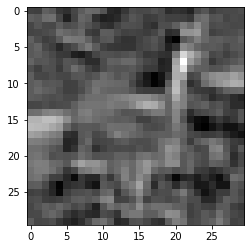

In [15]:
plt.imshow(output[0,0].detach(),cmap='gray')

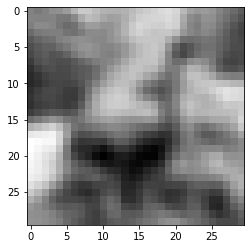

In [21]:
# 可以手动设置权重

with torch.no_grad():
    conv.bias.zero_()          # bias 设为0，去除干扰
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)   # 每个元素都设置为1/9，计算邻域内所有元素的均值

output = conv(img.unsqueeze(0))

plt.imshow(output[0,0].detach(),cmap='gray')
    


In [19]:
output.shape

torch.Size([1, 16, 30, 30])

In [32]:
conv = nn.Conv2d(3,1,kernel_size=3,padding=1)

with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:]=torch.tensor([[-1.0,0.0,1.0],
                                 [-1.0,0.0,1.0],
                                 [-1.0,0.0,1.0]])
    
    
output = conv(img.unsqueeze(0))

In [39]:
output[0,0]

tensor([[-1.3678, -5.2074,  ..., -1.6409,  1.2073],
        [-0.6942, -5.7819,  ..., -2.9649,  2.7501],
        ...,
        [ 2.5885, -0.6261,  ...,  4.7024,  4.4315],
        [ 2.4069, -0.5565,  ...,  3.1238,  3.0363]], grad_fn=<SelectBackward>)

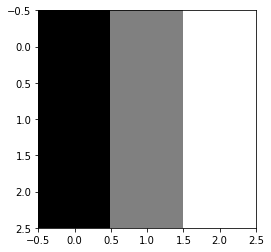

In [48]:
plt.imshow(conv.weight[0,0].detach().numpy(),cmap='gray')


In [50]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape,output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [52]:
model = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,8,kernel_size=3,padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # 
            nn.Linear(8*8*8,32),
            nn.Tanh(),
            nn.Linear(32,2))

In [57]:
##  建立nn.Model的子类
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8,32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)
        
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1,8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [59]:
model = Net()       # 实例化后，可以追踪参数

numel_list = [p.numel() for p in model.parameters()]

sum(numel_list),numel_list



(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
# 每个nn model  都有对应的函数，可以将没有参数的pool和than转换为函数形式
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self,x):
        out = F.max_pool2d(F.tanh(self.conv1(x)),2)  # 2 是max_pool2d 的参数
        out = F.max_pool2d(F.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = F.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out